# 0. Preamble

## 0.1. Connect to the Google shared folder "Capstone"

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/Capstone/'

/content/drive/My Drive/Capstone


In [ ]:
ls

 chroma_database/         final_eval_details.gsheet
 chroma_v3/              'GitHub related'/
 credentials/             Notebooks/
 datasets/                {persist_base_directory}vector_store_rcts_1500_small/
 Deliverables/            response_eval_accuracy.csv
 eval/                    response_eval_details.csv
 final_eval_details.csv


## 0.2. Install Dependencies

please install langchain required libraries: reference documentation  https://python.langchain.com/docs/how_to/installation/
<br> you will need your Open AI API key  https://platform.openai.com/api-keys


In [ ]:
!pip install langchain
!pip install langchain-community
!pip install langchain-experimental
!pip install pypdf
!pip install unstructured
!pip install lxml html5lib
!pip install langchain-openai
!pip install chromadb
!pip install openai
!pip install -U langchain-chroma
!pip install colbert
!pip install groq
!pip install --upgrade langchain openai
!pip install transformers -U



# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# tensorflow 2.17.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.0 which is incompatible.
# tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 5.29.0 which is incompatible.

# Dependency Conflict: tensorflow and tensorflow-metadata require a specific version of protobuf (<5 and >=3.20.3), but the version installed (protobuf 5.29.0) does not meet this requirement.
# Successful Installation: Despite the warning, chromadb and its dependencies were installed successfully.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.7/409.7 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.21
    Uninstalling langchain-core-0.3.21:
      Successfully uninstalled langchain-core-0.3.21
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.9
    Uninstalling langchain-0.3.9:
      Successfully uninstalled langchain-0.3.9
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.0/209.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 25.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/

In [ ]:
# install if using GPU

!pip install transformers torch accelerate bitsandbytes
!pip install -U bitsandbytes
!pip install --upgrade transformers bitsandbytes accelerate

# !pip install -U transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.3/336.3 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.1.1
    Uninstalling accelerate-1.1.1:
      Successfully uninstalled accelerate-1.1.1


## 0.3. Imports

In [ ]:
from dotenv import load_dotenv
import os
import time
import re
import math
import pickle
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gspread
import shutil
from sklearn.preprocessing import normalize

import torch
import transformers
from transformers import pipeline, AutoTokenizer, AutoModel, AutoModelForCausalLM, BitsAndBytesConfig

import openai

from langchain_community.document_loaders import UnstructuredHTMLLoader
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents.base import Document
from langchain.embeddings.base import Embeddings
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma

from langchain.schema import SystemMessage, HumanMessage

import groq
from groq import Client, Groq

# from google.colab import userdata

## 0.4. API Keys

<font color=red>delete below cell when share</font>

In [ ]:
# replace with your credentials
env_content = """
GROQ_API_KEY=
OPENAI_API_KEY=
HF_TOKEN=
"""

with open('credentials/claire.env', 'w') as f:   # replace it with your env filename
    f.write(env_content)

In [ ]:
load_dotenv('credentials/claire.env', override=True) # replace it with your env filename

groq_api_key = os.getenv('GROQ_API_KEY')
huggingface_key = os.getenv('HF_TOKEN')
openai_api_key = os.getenv('OPENAI_API_KEY')


<br>

# 1. Loading Documents

In [ ]:
# Load all_documents from the pickle file
pickle_file_path = "datasets/pickle_files/all_documents.pkl"
try:
    with open(pickle_file_path, "rb") as f:
        all_documents = pickle.load(f)
    print(f"Loaded {len(all_documents)} documents from {pickle_file_path}")
except FileNotFoundError:
    print(f"Pickle file {pickle_file_path} not found. Run the document loading process first.")


Loaded 1782 documents from datasets/pickle_files/all_documents.pkl


In [ ]:
# Check loaded documents

print(f"Total documents loaded: {len(all_documents)}")
if all_documents:
    print("Sample document metadata:", all_documents[0].metadata)
    print("Sample document content:", all_documents[0].page_content[:500])

Total documents loaded: 1782
Sample document metadata: {'source': 'sec_filings/meta_filings/META_1326801_2024-10-31_10-Q.html', 'date': '2024-10-31', 'document_type': '10-Q'}
Sample document content: UNITED STATES

SECURITIES AND EXCHANGE COMMISSION

Washington, D.C. 20549

____________________________________________

FORM

____________________________________________

(Mark One)

QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934

For the quarterly period ended

or

TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934

For the transition period from to

Commission File Number:

________________________________________


<br>

# 2. Chunking Documents

In [ ]:
chunk_sizes = [500, 1000, 1500]

## 2.1. Recursive Character Text Splitter Chunking

#### Recursive Character Text Splitter is useful for splitting text into smaller chunks based on separators and ensuring overlap between chunks for context retention. This is the recommended text splitter for generic text use cases.

In [ ]:
# Use RecursiveCharacterTextSplitter for chunking

def rcts_chunking(chunk_size=1000, chunk_overlap=200):
  text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap, separators=["\n\n","\n","."," "])
  return text_splitter.split_documents(all_documents)

In [ ]:
chunk_results_rcts = {}

for size in chunk_sizes:
    chunk_overlaps = math.ceil(size * 0.2)
    chunk_name = f"chunks_rcts_{size}"
    chunk_results_rcts[chunk_name] = rcts_chunking(size, chunk_overlaps)

for name, result in chunk_results_rcts.items():
    print(f"The length of {name} is {len(result)}")

The length of chunks_rcts_500 is 40356
The length of chunks_rcts_1000 is 19939
The length of chunks_rcts_1500 is 13122


In [ ]:
for i, chunk in enumerate (chunk_results_rcts['chunks_rcts_1000'][:2]):
    print(f"Chunk {i+1} :\n{chunk.page_content}\n")

Chunk 1 :
UNITED STATES

SECURITIES AND EXCHANGE COMMISSION

Washington, D.C. 20549

____________________________________________

FORM

____________________________________________

(Mark One)

QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934

For the quarterly period ended

or

TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934

For the transition period from to

Commission File Number:

____________________________________________

(Exact name of registrant as specified in its charter)

____________________________________________

Delaware 20-1665019 (State or other jurisdiction of incorporation or organization) (I.R.S. Employer Identification Number)

, ,

(Address of principal executive offices and Zip Code)

()

(Registrant's telephone number, including area code)

____________________________________________

Securities registered pursuant to Section 12(b) of the Act:

Chunk 2 :
()

(Registrant's telep

## 2.2. Semantic Chunking

#### Instead of splitting based on characters or separators, it uses NLP techniques to chunk text based on semantic meaning. This method ensures that chunks are coherent units of thought, such as paragraphs or sections.

In [ ]:
def semantic_chunking(chunk_size=1000, summarize=False):
    summarizer = pipeline("summarization", model="t5-small") if summarize else None
    all_chunks = []

    for document in all_documents:
        text = document.page_content
        chunks = []
        start = 0
        while start < len(text):
            end = start + chunk_size
            segment = text[start:end]
            if summarize and len(segment) >= chunk_size:  # Summarize only if enabled
                summary = summarizer(segment, max_length=150, min_length=30, do_sample=False)
                chunks.append(summary[0]['summary_text'])
            else:
                chunks.append(segment)  # Keep original content if not summarizing
            start = end

        # Convert each chunk to a LangChain Document and add metadata
        for chunk in chunks:
            all_chunks.append(Document(page_content=chunk, metadata={"source": "semantic_chunk"}))

    return all_chunks

In [ ]:
chunk_results_semantic = {}

for size in chunk_sizes:
    chunk_name = f"chunks_semantic_{size}"
    chunk_results_semantic[chunk_name] = semantic_chunking(size)

for name, result in chunk_results_semantic.items():
    print(f"The length of {name} is {len(result)}")

The length of chunks_semantic_500 is 27945
The length of chunks_semantic_1000 is 14441
The length of chunks_semantic_1500 is 9975


In [ ]:
for i, chunk in enumerate (chunk_results_semantic['chunks_semantic_1000'][:2]):
    print(f"Chunk {i+1} :\n{chunk.page_content}\n")

Chunk 1 :
UNITED STATES

SECURITIES AND EXCHANGE COMMISSION

Washington, D.C. 20549

____________________________________________

FORM

____________________________________________

(Mark One)

QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934

For the quarterly period ended

or

TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934

For the transition period from to

Commission File Number:

____________________________________________

(Exact name of registrant as specified in its charter)

____________________________________________

Delaware 20-1665019 (State or other jurisdiction of incorporation or organization) (I.R.S. Employer Identification Number)

, ,

(Address of principal executive offices and Zip Code)

()

(Registrant's telephone number, including area code)

____________________________________________

Securities registered pursuant to Section 12(b) of the Act:

Title of each class Trading symbo

## 2.3. Visualizing actual chunk size

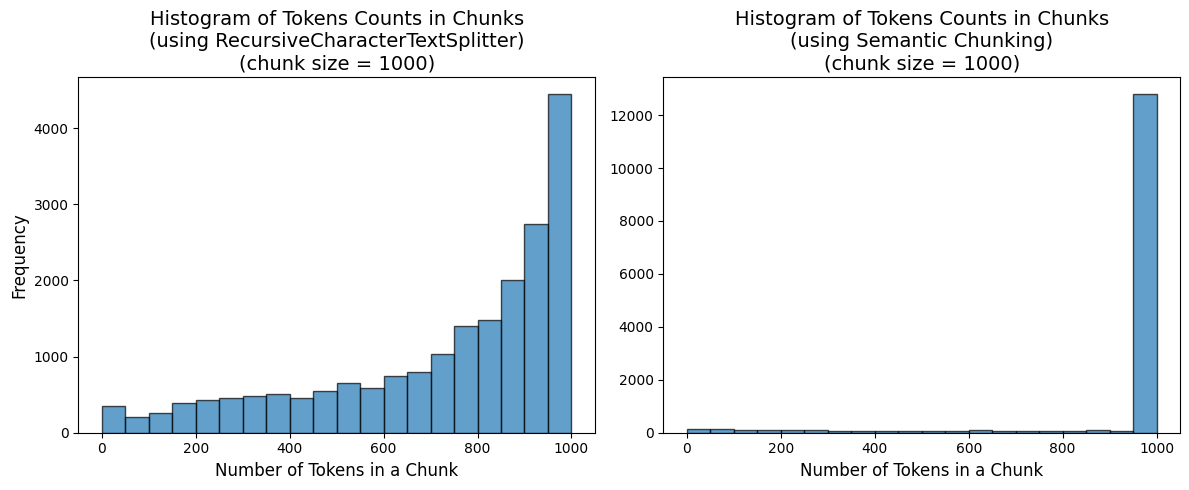

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

chunk_results_rcts_1000 = chunk_results_rcts['chunks_rcts_1000']
char_counts_rcts_1000 = [len(chunk.page_content) for chunk in chunk_results_rcts_1000]

chunk_results_semantic_1000 = chunk_results_semantic['chunks_semantic_1000']
char_counts_semantic_1000 = [len(chunk.page_content) for chunk in chunk_results_semantic_1000]

axes[0].hist(char_counts_rcts_1000, bins=np.arange(0, max(char_counts_rcts_1000) + 50, 50), edgecolor='black', alpha=0.7)
axes[0].set_title("Histogram of Tokens Counts in Chunks\n(using RecursiveCharacterTextSplitter)\n(chunk size = 1000)", fontsize=14)
axes[0].set_xlabel("Number of Tokens in a Chunk", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

axes[1].hist(char_counts_semantic_1000, bins=np.arange(0, max(char_counts_semantic_1000) + 50, 50), edgecolor='black', alpha=0.7)
axes[1].set_title("Histogram of Tokens Counts in Chunks\n(using Semantic Chunking)\n(chunk size = 1000)", fontsize=14)
axes[1].set_xlabel("Number of Tokens in a Chunk", fontsize=12)

plt.tight_layout()

plt.show()

<br>

# 3. Embedding & Persist Vector Store

Testing different methods of generating embeddings is a great way to optimize for accuracy, efficiency, and domain specificity.



## 3.1. Embedding models

In [ ]:
embedding_small = OpenAIEmbeddings(model ="text-embedding-3-small")

embedding_ada = OpenAIEmbeddings(model="text-embedding-ada-002")

In [ ]:
# FinBERT are tailored to financial or legal documents
class FinBERTEmbeddings(Embeddings):
    def __init__(self, model_name="yiyanghkust/finbert-tone", max_length=512):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.max_length = max_length

    def embed_documents(self, documents):
        # Convert a list of documents to embeddings
        return [self._embed_text(doc) for doc in documents]

    def embed_query(self, query):
        # Convert a single query to an embedding
        return self._embed_text(query)

    def _embed_text(self, text):
        # Tokenize and encode the text
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=self.max_length)
        with torch.no_grad():
            outputs = self.model(**inputs)
            # Use the mean of the token embeddings (can customize based on use case)
            embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        return embeddings

embedding_FinBERT = FinBERTEmbeddings()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [ ]:
# class FinBERTEmbeddings(Embeddings):
#     def __init__(self, model_name="yiyanghkust/finbert-tone", max_length=512):
#         self.tokenizer = AutoTokenizer.from_pretrained(model_name)
#         self.model = AutoModel.from_pretrained(model_name)
#         self.max_length = max_length

#     def embed_documents(self, chunks):
#         # Directly embed pre-chunked text
#         embeddings = [self._embed_text(chunk) for chunk in chunks]
#         return normalize(embeddings, norm='l2')

#     def embed_query(self, query):
#         return normalize([self._embed_text(query)], norm='l2')[0]

#     def _embed_text(self, text):
#         inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=self.max_length)
#         with torch.no_grad():
#             outputs = self.model(**inputs)
#             cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
#         return cls_embedding


# embedding_FinBERT2 = FinBERTEmbeddings()

## 3.2. Create and Persist Vector Stores


In [ ]:
# # manual create verctor stores one by one for testing purpose ONLY

# persist_base_directory = 'chroma_test/'

# if not os.path.exists(persist_base_directory):
#     os.makedirs(persist_base_directory)
# if not os.access(persist_base_directory, os.W_OK):
#     os.chmod(persist_base_directory, 0o777)

# chunks = chunk_results_rcts['chunks_rcts_1500']
# # chunks = chunk_results_semantic['chunks_semantic_1500']


# Chroma.from_documents(
#         documents=chunks,
#         embedding=embedding_small,
#         persist_directory='{persist_base_directory}vector_store_rcts_1500_small'
#     )

In [ ]:
def create_and_persist_vector_store(chunks, embedding_model, persist_directory):
    """
    Creates and persists a vector store using the given documents, embedding model, and directory.

    :param chunks: List of document chunks to embed
    :param embedding_model: Embedding model to use
    :param persist_directory: Directory to save the vector store
    """
    from langchain_chroma import Chroma

    Chroma.from_documents(
        documents=chunks,
        embedding=embedding_model,
        persist_directory=persist_directory
    )

### <font color='red'>  delete the target folder before running below code to avoid messing up the data </font>

In [ ]:
# Embedding models
embedding_models = {
    "small": embedding_small,
    "ada": embedding_ada,
    "FinBERT": embedding_FinBERT
}

# Chucking methods
chunk_results = {
    "rcts": chunk_results_rcts,
    "semantic": chunk_results_semantic
}

persist_base_directory = 'chroma_database/'
if not os.path.exists(persist_base_directory):
    os.makedirs(persist_base_directory)
if not os.access(persist_base_directory, os.W_OK):
    os.chmod(persist_base_directory, 0o777)

# Iterate over embedding models, chunking methods, and chunk sizes
for embedding_name, embedding_model in embedding_models.items():
    for chunk_type, chunk_data in chunk_results.items():
        for chunk_key, chunks in chunk_data.items():
            chunk_size = chunk_key.split("_")[-1]  # Extract the size (e.g., "500", "1000", etc.)
            persist_directory = f"{persist_base_directory}vector_store_{chunk_type}_{chunk_size}_{embedding_name}"
            # print(persist_directory)
            create_and_persist_vector_store(chunks, embedding_model, persist_directory)

<br>

# 4. Load Vector Stores

### <font color='blue'>The embedding_function must be the same as the one used when creating the vector store. <font>

In [ ]:
embedding_small = OpenAIEmbeddings(model ="text-embedding-3-small")

embedding_ada = OpenAIEmbeddings(model="text-embedding-ada-002")

In [ ]:
# FinBERT are tailored to financial or legal documents
class FinBERTEmbeddings(Embeddings):
    def __init__(self, model_name="yiyanghkust/finbert-tone", max_length=512):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.max_length = max_length

    def embed_documents(self, documents):
        # Convert a list of documents to embeddings
        return [self._embed_text(doc) for doc in documents]

    def embed_query(self, query):
        # Convert a single query to an embedding
        return self._embed_text(query)

    def _embed_text(self, text):
        # Tokenize and encode the text
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=self.max_length)
        with torch.no_grad():
            outputs = self.model(**inputs)
            # Use the mean of the token embeddings (can customize based on use case)
            embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        return embeddings

embedding_FinBERT = FinBERTEmbeddings()

In [ ]:
# # manual load for testing purpose only
# vector_store_rcts_1500_small = Chroma(
#     persist_directory="chroma/vector_store_rcts_1500_small",
#     embedding_function=embedding_small
# )

# vector_store = vector_store_rcts_1500_small

In [ ]:
def load_vector_stores(base_directory, embedding_models):
    """
    Loads all vector stores from the given base directory dynamically based on the naming convention.

    :param base_directory: Directory where the vector stores are saved
    :param embedding_models: Dictionary mapping embedding names to embedding objects
    :return: Dictionary of loaded vector stores
    """
    vector_stores = {}

    for root, dirs, files in os.walk(base_directory):
        for dir_name in dirs:
            # Parse directory name to extract chunk type, size, and embedding model
            parts = dir_name.split("_")
            if len(parts) >= 4:
                chunk_type = parts[2]
                chunk_size = parts[3]
                embedding_name = parts[4]

                # Check if the embedding model exists
                if embedding_name in embedding_models:
                    persist_directory = os.path.join(root, dir_name)
                    embedding_model = embedding_models[embedding_name]

                    # Load the vector store
                    vector_store_key = f"vector_store_{chunk_type}_{chunk_size}_{embedding_name}"
                    vector_stores[vector_store_key] = Chroma(
                        persist_directory=persist_directory,
                        embedding_function=embedding_model
                    )

    return vector_stores

# Embedding models
embedding_models = {
    "small": embedding_small,
    "ada": embedding_ada,
    "FinBERT": embedding_FinBERT
}

# Load all vector stores
base_directory = "chroma_database"
all_vector_stores = load_vector_stores(base_directory, embedding_models)

In [ ]:
print(f'Successfully loaded {len(all_vector_stores.keys())} vector stores:')
print(all_vector_stores.keys())

Successfully loaded 18 vector stores:
dict_keys(['vector_store_rcts_500_small', 'vector_store_rcts_1000_small', 'vector_store_rcts_1500_small', 'vector_store_semantic_500_small', 'vector_store_semantic_1000_small', 'vector_store_semantic_1500_small', 'vector_store_rcts_500_ada', 'vector_store_rcts_1000_ada', 'vector_store_rcts_1500_ada', 'vector_store_semantic_500_ada', 'vector_store_semantic_1000_ada', 'vector_store_semantic_1500_ada', 'vector_store_rcts_500_FinBERT', 'vector_store_rcts_1000_FinBERT', 'vector_store_rcts_1500_FinBERT', 'vector_store_semantic_500_FinBERT', 'vector_store_semantic_1000_FinBERT', 'vector_store_semantic_1500_FinBERT'])
